In [1]:
from fastai.tabular.all import *
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import *
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import warnings
warnings.simplefilter('ignore', FutureWarning)
from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [2]:
df = pd.read_csv('C:/Users/light/Desktop/archive_txt_2/host_train.csv')

In [3]:
df.columns

Index(['case_id', 'Hospital', 'Hospital_type', 'Hospital_city',
       'Hospital_region', 'Available_Extra_Rooms_in_Hospital', 'Department',
       'Ward_Type', 'Ward_Facility', 'Bed_Grade', 'patientid',
       'City_Code_Patient', 'Type of Admission', 'Illness_Severity',
       'Patient_Visitors', 'Age', 'Admission_Deposit', 'Stay_Days'],
      dtype='object')

In [4]:
df.head()

,case_id,Hospital,Hospital_type,Hospital_city,...,Patient_Visitors,Age,Admission_Deposit,Stay_Days
0,1,8,2,3,...,2,51-60,4911.0,0-10
1,2,2,2,5,...,2,51-60,5954.0,41-50
2,3,10,4,1,...,2,51-60,4745.0,31-40
3,4,26,1,2,...,2,51-60,7272.0,41-50
4,5,26,1,2,...,2,51-60,5558.0,41-50


In [ ]:
#df = df.drop(columns=['case_id', 'Admission_Deposit', 'patientid'])

In [ ]:
df.head()

In [ ]:
df.info()

In [5]:
df['Illness_Severity'].unique()

array(['Extreme', 'Moderate', 'Minor'], dtype=object)

In [6]:
illness_severity = 'Extreme', 'Moderate', 'Minor'

In [7]:
df['Illness_Severity'] = df['Illness_Severity'].astype('category')
df['Illness_Severity'].cat.set_categories(illness_severity, ordered=True, inplace=True)

In [8]:
dep_var = 'Stay_Days'

In [9]:
procs = [Categorify, FillMissing]

In [10]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)
cont,cat

(['case_id',
  'Hospital',
  'Hospital_type',
  'Hospital_city',
  'Hospital_region',
  'Available_Extra_Rooms_in_Hospital',
  'Bed_Grade',
  'patientid',
  'City_Code_Patient',
  'Patient_Visitors',
  'Admission_Deposit'],
 ['Department',
  'Ward_Type',
  'Ward_Facility',
  'Type of Admission',
  'Illness_Severity',
  'Age'])

In [11]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [12]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits, y_block = CategoryBlock)

In [13]:
len(to.train),len(to.valid)

(254751, 63687)

In [14]:
to.show(3)

,Department,Ward_Type,Ward_Facility,Type of Admission,Illness_Severity,Age,Bed_Grade_na,City_Code_Patient_na,case_id,Hospital,Hospital_type,Hospital_city,Hospital_region,Available_Extra_Rooms_in_Hospital,Bed_Grade,patientid,City_Code_Patient,Patient_Visitors,Admission_Deposit,Stay_Days
308282,gynecology,R,B,Urgent,Moderate,21-30,False,False,308283,12,0,9,1,4,2.0,122579,7.0,2,4465.0,11-20
315736,gynecology,R,C,Trauma,Minor,21-30,False,False,315737,27,0,7,1,4,3.0,73746,8.0,2,4515.0,11-20
230013,gynecology,Q,E,Trauma,Moderate,31-40,False,False,230014,14,0,1,0,4,2.0,11494,7.0,4,4560.0,11-20


In [15]:
to.items.head(3)

,case_id,Hospital,Hospital_type,Hospital_city,...,Admission_Deposit,Stay_Days,Bed_Grade_na,City_Code_Patient_na
308282,308283,12,0,9,...,4465.0,1,1,1
315736,315737,27,0,7,...,4515.0,1,1,1
230013,230014,14,0,1,...,4560.0,1,1,1


In [16]:
to.classes['Illness_Severity']

['#na#', 'Extreme', 'Moderate', 'Minor']

In [17]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [39]:
m = DecisionTreeClassifier(max_leaf_nodes=11)
m.fit(xs, y);

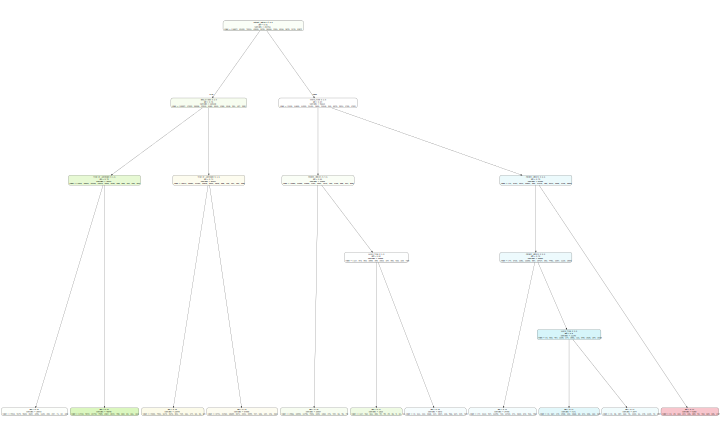

In [40]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

In [41]:
m = DecisionTreeClassifier()
m.fit(xs, y);

In [42]:
m.score(xs, y)

1.0

In [43]:
m.score(valid_xs, valid_y)

0.3014743982288379

In [44]:
m.get_n_leaves(), len(xs)

(114304, 254751)

In [53]:
m = DecisionTreeClassifier(min_samples_leaf=19000)
m.fit(xs, y);
m.score(xs, y), m.score(valid_xs, valid_y)

(0.35915855089872073, 0.3558654042426241)

In [54]:
m.get_n_leaves()

11

In [55]:
def rf(xs, y, n_estimators=100, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [56]:
m = rf(xs, y);

In [57]:
m.score(xs, y), m.score(valid_xs, valid_y)

(0.7028863478455433, 0.42171871810573586)

In [58]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [59]:
accuracy_score(np.amax(preds, axis=0), valid_y)

0.049287923752100116

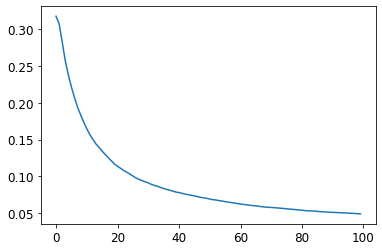

In [60]:
plt.plot([accuracy_score(np.amax(preds[:i+1], axis=0), valid_y) for i in range(100)])

In [61]:
accuracy_score((m.oob_decision_function_).argmax(axis=-1), y)

0.4183143540162747

In [62]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [63]:
preds.shape

(100, 63687)

In [64]:
preds_std = preds.std(0)

In [65]:
preds_std[:5]

array([1.67029937, 1.40978722, 1.13030969, 0.71351244, 0.80467385])

In [66]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [67]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
18,Admission_Deposit,0.157142
8,case_id,0.146705
17,Patient_Visitors,0.143534
15,patientid,0.139562
5,Age,0.057406
1,Ward_Type,0.057052
16,City_Code_Patient,0.055462
9,Hospital,0.043215
13,Available_Extra_Rooms_in_Hospital,0.039867
14,Bed_Grade,0.033706


In [68]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)

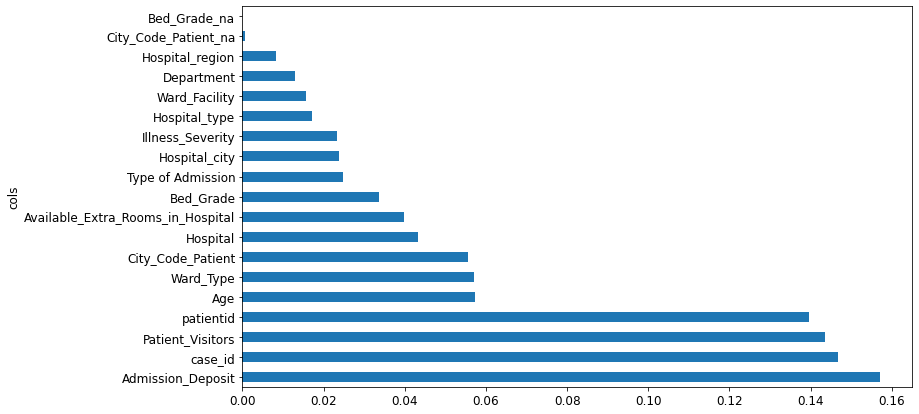

In [69]:
plot_fi(fi);

In [70]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

17

In [71]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [72]:
m = rf(xs_imp, y)

In [73]:
m.score(xs_imp, y), m.score(valid_xs_imp, valid_y)

(0.7015006810571892, 0.4218443324383312)

In [74]:
len(xs.columns), len(xs_imp.columns)

(19, 17)

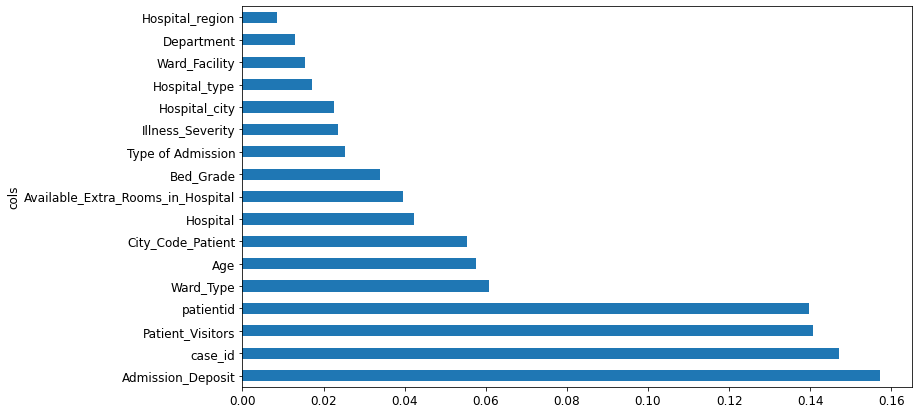

In [75]:
plot_fi(rf_feat_importance(m, xs_imp));

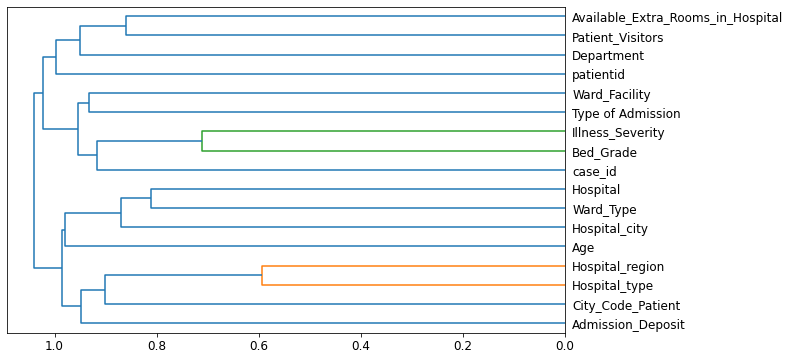

In [76]:
cluster_columns(xs_imp)

In [77]:
def get_oob(df):
    m = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf=19000, oob_score=True)
    m.fit(df, y)
    return m.oob_decision_function_

In [78]:
get_oob(xs_imp).argmax(axis=-1)

array([2, 1, 2, ..., 1, 2, 2], dtype=int64)

In [79]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp

In [80]:
m = rf(xs_final, y)
m.score(xs_final, y), m.score(valid_xs_final, valid_y)

(0.7008569151838462, 0.4221897718529684)

In [81]:
row = valid_xs_final.iloc[:10]

In [82]:
predictions, bias, contributions = treeinterpreter.predict(m, row.values)

In [83]:
predictions[0], bias[0], contributions[0]

(array([0.        , 0.14398199, 0.00326923, 0.44301028, 0.00428571, 0.28690848, 0.00414787, 0.04591389, 0.04422486, 0.00542857, 0.01882912]),
 array([0.07389295, 0.24510045, 0.2756009 , 0.1724138 , 0.0368051 , 0.11054985, 0.0086635 , 0.032269  , 0.01518625, 0.00853345, 0.02098475]),
 array([[-3.19099415e-03, -1.19832762e-03, -4.73383802e-03, -4.15007777e-03, -3.84228001e-03,  2.05707477e-02, -3.78288755e-03,  2.46381658e-03, -2.71677524e-03, -6.28292252e-04,  1.20890838e-03],
        [ 9.21671389e-05, -1.78129358e-03, -2.09375833e-03,  6.96963336e-03, -3.76619048e-03,  3.11837988e-03, -1.52459547e-03,  1.26651133e-03, -8.76204812e-04,  1.67197863e-03, -3.07662766e-03],
        [-6.35339039e-02, -1.49041506e-01, -1.81182054e-01,  8.97073506e-02, -1.06782108e-02,  1.82323916e-01,  2.82342349e-03,  3.89460038e-02,  5.57866084e-02,  8.26672818e-03,  2.65816448e-02],
        [ 2.66662407e-05, -3.09698436e-03, -2.09709468e-03, -1.93261900e-02,  1.38036136e-03,  2.21846364e-02,  1.82575385e-0

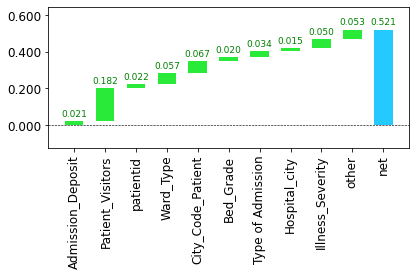

In [84]:
waterfall(valid_xs_final.columns, np.amax(contributions[0], axis=-1), threshold=0.08, rotation_value=90,formatting='{:,.3f}');